In [166]:
%pylab inline
from __future__ import (division, print_function)

import os
import sys
import copy
import glob
import fnmatch
import warnings

# Numpy & Scipy
import scipy
import numpy as numpy 

# Astropy related
from astropy.io import fits 
from astropy import wcs
from astropy import units as u
from astropy.table import Table, Column, vstack, join
from astropy.stats import sigma_clip
from astropy.cosmology import FlatLambdaCDM as cosmo
cosmo = cosmo(H0=70, Om0=0.3)

# Matplotlib 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator

# AstroML
from astroML.plotting import hist
# plt.ioff()

# Color map 
from palettable.colorbrewer.sequential import Oranges_4, Blues_5
ORG4 = Oranges_4.mpl_colormap
BLU5 = Blues_5.mpl_colormap

# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 1.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 1.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 1.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['legend.numpoints'] = 1
rc('axes', linewidth=2)

# Shapely related imports
from shapely.geometry import Polygon, LineString, Point
from shapely          import wkb
from shapely.ops      import cascaded_union
from shapely.prepared import prep
from descartes import PolygonPatch

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [295]:
# SDSS pivot wavelength 
sdss_u_pivot = 3551.0
sdss_g_pivot = 4686.0
sdss_r_pivot = 6165.0
sdss_i_pivot = 7481.0
sdss_z_pivot = 8931.0

# GALEX pivot wavelength 
galex_fuv_pivot = 1535.0
galex_nuv_pivot = 2301.0

# WISE pivot wavelength 
wise_w1_pivot = 34000.0
wise_w2_pivot = 46000.0

# HSC pivot wavelength 
hsc_g_pivot = 4782.2
hsc_r_pivot = 6101.7 
hsc_i_pivot = 7648.0 
hsc_z_pivot = 8883.0
hsc_y_pivot = 9750.8

hscFiltWave = np.asarray([hsc_g_pivot, hsc_r_pivot, hsc_i_pivot, hsc_z_pivot, hsc_y_pivot])

"""
Absolute magnitude of the Sun in HSC filters
Right now, just use the DES filters
"""
SUN_G = 5.08
SUN_R = 4.62
SUN_I = 4.52
SUN_Z = 4.52
SUN_Y = 4.51

# Solar stellar metallicity 
Z_SUN = 0.02

# definitions for the axes
left, width    = 0.155, 0.66
right          = left + width 
bottom, height = 0.13, 0.86
bottom_h = left_h = left + width + 0.02
recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.18, height]

# Color 
BLUE0 = "#92c5de"
BLUE1 = "#0571b0"
RED0 = "#f4a582"
RED1 = "#ca0020"

In [3]:
def columnExplode(inputCat, column):
    """Explode the array column into column of each bands."""
    table = copy.deepcopy(inputCat)
    # Separate the columns
    col_g = table[column][:,0]
    col_r = table[column][:,1]
    col_i = table[column][:,2]
    col_z = table[column][:,3]
    # Rename them 
    col_g.name = column + '_G'
    col_r.name = column + '_R'
    col_i.name = column + '_I'
    col_z.name = column + '_Z'
    # Add back 
    table.add_column(col_g)
    table.add_column(col_r)
    table.add_column(col_i)
    table.add_column(col_z)
    # 
    if table[column].shape[1] == 5:
        col_y = table[column][:,4]
        col_y.name = column + '_Y'
        table.add_column(col_y)  
    # Remove old column
    table.remove_column(column)
    
    return table

In [62]:
def songPlotSetup(ax, border=4.5, 
                  xlabel=30, ylabel=30,
                  majorTickL=12, minorTickL=8, 
                  majorTickW=4.5, minorTickW=4.0):
    """Setup the format of the figure."""
    # Axes setup
    #  Minor Ticks on 
    ax.minorticks_on()
    #  Axes Thickness
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(border)
    
    #  Tick Label Size 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(xlabel) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(ylabel) 
    
    #  Tick Length and Width
    ax.tick_params('both', length=majorTickL, width=majorTickW, 
                   which='major')
    ax.tick_params('both', length=minorTickL, width=minorTickW, 
                   which='minor')
    
    return ax

In [5]:
def getObsLogM2L(inputCat, filtUse='I', amag_sun=SUN_I):
    """Use MSTAR, Z, and MAGGIES_FILT to estimate the log(M2L)."""
    table = copy.deepcopy(inputCat)
    # Get the distance module 
    distMod = cosmo.distmod(table['Z']).value
    # Get the absolute magnitudes 
    maggieCol = 'MAGGIES_' + filtUse
    absmag = (np.log10(table[maggieCol].data) / -0.4) - distMod
    # Estimate the luminosity
    logLum = (amag_sun - absmag) / 2.5
    logLumCol = 'LOGLUM_' + filtUse + '_OBS'
    # Estimate the log(M/L)
    logM2L = table['MSTAR'].data - logLum
    logM2LCol = 'LOGM2L_' + filtUse + '_OBS'
    # Add new columns 
    table.add_column(Column(logLum, name=logLumCol))
    table.add_column(Column(logM2L, name=logM2LCol))
    
    return table

In [6]:
def getKcorLogM2L(inputCat, filtUse='I', amag_sun=SUN_I):
    """Use MSTAR, Z, and MAGGIES_FILT to estimate the log(M2L)."""
    table = copy.deepcopy(inputCat)
    # Get the absolute magnitudes 
    absmagCol = 'ABSMAG_' + filtUse
    absmag = table[absmagCol].data
    # Estimate the luminosity
    logLum = (amag_sun - absmag) / 2.5
    logLumCol = 'LOGLUM_' + filtUse + '_KCOR'
    # Estimate the log(M/L)
    logM2L = table['MSTAR'].data - logLum
    logM2LCol = 'LOGM2L_' + filtUse + '_KCOR'
    # Add new columns 
    table.add_column(Column(logLum, name=logLumCol))
    table.add_column(Column(logM2L, name=logM2LCol))
    
    return table

In [207]:
def combineSedResults(sed_run, model_str, sed_loc='./', kcorZ='0.0'):
    """Combine the ISEDFIT and KCORRECT results."""
    # Name of the result file
    file_result = os.path.join(sed_loc, sed_run + '_' + model_str + '.fits.gz')
    file_kcorr = os.path.join(sed_loc, sed_run + '_' + model_str + '_kcorr.z' + 
                              kcorZ + '.fits.gz')
    file_post = os.path.join(sed_loc, sed_run + '_' + model_str + '_post.fits.gz')

    # Read in the SED fitting results 
    if not os.path.isfile(file_result): 
        raise Exception("Can not find the ISEDFIT RESULT: %s" % file_result)
    else:
        sed_result = Table.read(file_result, format='fits')

    # Read in the Kcorrect results 
    if not os.path.isfile(file_kcorr): 
        raise Exception("Can not find the KCORRECT RESULT: %s" % file_kcorr)
    else:
        sed_kcorr = Table.read(file_kcorr, format='fits')

    # New output catalog 
    file_output = sed_run + '.fits'

    # Select the useful columns 
    useful_result = ['ISEDFIT_ID', 'RA', 'DEC', 'Z', 'MAGGIES', 'IVARMAGGIES', 'BESTMAGGIES', 'CHI2', 
                     'MSTAR', 'AGE', 'SFRAGE', 'TAU', 'ZMETAL', 'AV', 'MU', 
                     'MSTAR_ERR', 'AGE_ERR', 'SFRAGE_ERR', 'TAU_ERR', 'ZMETAL_ERR', 'AV_ERR', 'MU_ERR']
    useful_kcorr = ['ISEDFIT_ID', 'CHI2', 'KCORRECT', 'ABSMAG', 'IVARABSMAG', 'SYNTH_ABSMAG']

    # Isolate the useful columns into new tables 
    new_result = sed_result[useful_result]
    new_kcorr = sed_kcorr[useful_kcorr]

    # Rename the chi^2 columns
    new_result.rename_column('CHI2', 'CHI2_SED')
    new_kcorr.rename_column('CHI2', 'CHI2_KCORR')

    # Join the two tables
    new_combine = join(new_result, new_kcorr, keys='ISEDFIT_ID')
    
    # Get the relative metallicity 
    zmetalRel = (new_combine['ZMETAL'] / Z_SUN)
    new_combine.add_column(Column(zmetalRel, name='ZMET_REL'))

    # Explode the columns in SED catalogs
    new_combine = columnExplode(new_combine, 'MAGGIES')
    new_combine = columnExplode(new_combine, 'IVARMAGGIES')
    new_combine = columnExplode(new_combine, 'BESTMAGGIES')
    
    # Magnitude differences
    new_combine.add_column(Column(
            (2.5 * np.log10(new_combine['BESTMAGGIES_G'] / new_combine['MAGGIES_G'])), 
             name='DMAG_G'))
    new_combine.add_column(Column(
            (2.5 * np.log10(new_combine['BESTMAGGIES_R'] / new_combine['MAGGIES_R'])), 
             name='DMAG_R'))    
    new_combine.add_column(Column(
            (2.5 * np.log10(new_combine['BESTMAGGIES_I'] / new_combine['MAGGIES_I'])), 
             name='DMAG_I'))
    new_combine.add_column(Column(
            (2.5 * np.log10(new_combine['BESTMAGGIES_Z'] / new_combine['MAGGIES_Z'])), 
             name='DMAG_Z'))
    try:
        new_combine.add_column(Column(
                (2.5 * np.log10(new_combine['BESTMAGGIES_Y'] / new_combine['MAGGIES_Y'])), 
                 name='DMAG_Y'))
    except Exception: 
        pass
    
    # Explode the columns in Kcorrect catalogs
    new_combine = columnExplode(new_combine, 'KCORRECT')
    new_combine = columnExplode(new_combine, 'ABSMAG')
    new_combine = columnExplode(new_combine, 'IVARABSMAG')
    new_combine = columnExplode(new_combine, 'SYNTH_ABSMAG')

    # logM2L in observed frame 
    new_combine = getObsLogM2L(new_combine, filtUse='I', amag_sun=SUN_I)
    new_combine = getObsLogM2L(new_combine, filtUse='G', amag_sun=SUN_G)
    new_combine = getObsLogM2L(new_combine, filtUse='R', amag_sun=SUN_R)
    new_combine = getObsLogM2L(new_combine, filtUse='Z', amag_sun=SUN_Z)
    try:
        new_combine = getObsLogM2L(new_combine, filtUse='Y', amag_sun=SUN_Y)
    except Exception:
        pass

    # logM2L in rest frame
    new_combine = getKcorLogM2L(new_combine, filtUse='I', amag_sun=SUN_I)
    new_combine = getKcorLogM2L(new_combine, filtUse='G', amag_sun=SUN_G)
    new_combine = getKcorLogM2L(new_combine, filtUse='R', amag_sun=SUN_R)
    new_combine = getKcorLogM2L(new_combine, filtUse='Z', amag_sun=SUN_Z)
    try:
        new_combine = getKcorLogM2L(new_combine, filtUse='Y', amag_sun=SUN_Y)
    except Exception:
        pass
    
    # Save the results to new table
    new_combine.write(file_output, format='fits', overwrite=True)

    return new_combine

In [8]:
def toColorArr(data, bottom=None, top=None):
    """ 
    Convert a data array to "color array" (between 0 and 1). 
    
    Parameters:
        bottom, top  : 
    """
    if top is not None:
        data[data >= top] = top
    if bottom is not None:
        data[data <= bottom] = bottom
        
    return ((data - np.nanmin(data)) / 
            (np.nanmax(data) - np.nanmin(data))) * 255.0

In [9]:
def toSizeArr(data, bottom=None, top=None, maxSize=40):
    """ 
    Convert a data array to "size array". 
    
    Parameters:
        bottom, top  : 
    """
    if top is not None:
        data[data >= top] = top
    if bottom is not None:
        data[data <= bottom] = bottom
        
    return ((data - np.nanmin(data)) / 
            (np.nanmax(data) - np.nanmin(data))) * maxSize

In [196]:
def isedfitPlot(tableUse, colName1, colName2, titleUse=None, 
                colColor='CHI2_SED', colSize='Z', 
                cmap=ORG4, maxSize=350, alpha=0.8, 
                ax=None, xylim=True, nolabel=False, 
                titleSize=20, labelSize=36, 
                titleX=0.04, titleY=0.92, 
                xmargin=7.5, ymargin=7.5, noEdge=True):
    #---------------------------------------------------------#
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
        ax1 = fig.add_subplot(111)
    else:
        ax1 = ax
    
    # Formatting 
    ax1 = songPlotSetup(ax1)

    # Scatter plot 
    if noEdge:
        ax1.scatter(tableUse[colName1], 
                    tableUse[colName2], 
                    c=toColorArr(tableUse[colColor]), 
                    s=toSizeArr(tableUse[colSize], maxSize=maxSize), 
                    alpha=alpha, cmap=cmap, edgecolor='none')
    else:
        ax1.scatter(tableUse[colName1], 
                    tableUse[colName2], 
                    c=toColorArr(tableUse[colColor]), 
                    s=toSizeArr(tableUse[colSize], maxSize=maxSize), 
                    alpha=alpha, cmap=cmap)

    # Label
    if not nolabel:
        colnameUse1 = colName1.replace('_', '\_')
        colnameUse2 = colName2.replace('_', '\_')
        ax1.set_xlabel('$\mathrm{%s}$' % colnameUse1, size=labelSize)
        ax1.set_ylabel('$\mathrm{%s}$' % colnameUse2, size=labelSize)

    # Axis limits
    if xylim:
        xmin, xmax = np.nanmin(tableUse[colName1]), np.nanmax(tableUse[colName1])
        ymin, ymax = np.nanmin(tableUse[colName2]), np.nanmax(tableUse[colName2])
        xmargin, ymargin = ((xmax - xmin) / xmargin), ((ymax - ymin) / ymargin)
        ax1.set_xlim(xmin-xmargin, xmax+xmargin)
        ax1.set_ylim(ymin-ymargin, ymax+ymargin)

    # Title 
    if titleUse is not None:
        titleUse = titleUse.replace('_', '\_')
        ax1.text(titleX, titleY, '$\mathrm{%s}$' % titleUse, size=titleSize, 
                 transform = ax1.transAxes)
    #---------------------------------------------------------#
    
    if ax is None:
        return fig
    else:
        return ax1

In [195]:
def simpleScatter(xarr, yarr, 
                  xtick=True, ytick=True,
                  xstr=None, ystr=None, titleUse=None, 
                  carr=None, sarr=None, 
                  cmap=ORG4, maxSize=350, alpha=0.8, 
                  ax=None, xylim=True, nolabel=False, 
                  titleSize=20, labelSize=36, 
                  titleX=0.04, titleY=0.92, 
                  xmargin=7.5, ymargin=7.5, 
                  noEdge=True):
    #---------------------------------------------------------#
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
        ax1 = fig.add_subplot(111)
    else:
        ax1 = ax

    # Formatting 
        ax1 = songPlotSetup(ax1)
        
    # Color Array 
    if carr is None:
        carr = 'k'
    else:
        carr = toColorArr(carr)
      
    # Size Array
    if sarr is None: 
        sarr = 40 
    else: 
        sarr = toSizeArr(sarr, maxSize=maxSize)
    
    # Scatter plot
    if noEdge:
        ax1.scatter(xarr, yarr, c=carr, s=sarr, 
                    alpha=alpha, cmap=cmap, edgecolor='none')
    else:
        ax1.scatter(xarr, yarr, c=carr, s=sarr, 
                    alpha=alpha, cmap=cmap)

    # Label
    if xstr is not None:
        ax1.set_xlabel(xstr, size=labelSize)
    if ystr is not None:
        ax1.set_ylabel(ystr, size=labelSize)

    # Axis limits
    if xylim:
        xmin, xmax = np.nanmin(xarr), np.nanmax(xarr)
        ymin, ymax = np.nanmin(yarr), np.nanmax(yarr)
        xmargin, ymargin = ((xmax - xmin) / xmargin), ((ymax - ymin) / ymargin)
        ax1.set_xlim(xmin-xmargin, xmax+xmargin)
        ax1.set_ylim(ymin-ymargin, ymax+ymargin)

    # Title 
    if titleUse is not None:
        titleUse = titleUse.replace('_', '\_')
        ax1.text(titleX, titleY, '$\mathrm{%s}$' % titleUse, size=titleSize, 
                 transform = ax1.transAxes)
    #---------------------------------------------------------#
    if ax is None:
        return fig
    else: 
        return ax1

In [15]:
def simpleHist(tableUse, colName, sample1=None, bins='knuth',
               alpha=0.5, table2=None, sample2=None, 
               showLegend=True, useLog=False):
    #---------------------------------------------------------#
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
    ax1 = fig.add_subplot(111)
    # Formatting 
    ax1 = songPlotSetup(ax1)

    # RedMapper 
    if sample1 is None: 
        sample1 = 'Sample\ 1'
        
    if useLog:
        hist(np.log10(tableUse[colName]), bins=bins, histtype='stepfilled',
             color='b', alpha=alpha, normed=True, 
             label=sample1, ax=ax1)
    else:
        hist(tableUse[colName], bins=bins, histtype='stepfilled',
             color='b', alpha=alpha, normed=True, 
             label=sample1, ax=ax1)

    # Label
    colnameUse = colName.replace('_', '\_')
    if useLog: 
        ax1.set_xlabel('$\log\ \mathrm{%s}$' % colnameUse, size=36)
    else: 
        ax1.set_xlabel('$\mathrm{%s}$' % colnameUse, size=36)

    ax1.set_ylabel('$\mathrm{\#}$', size=36)
    
    # Secondary sample ? 
    if table2 is not None: 
        if sample2 is None: 
            sample2 = 'Sample\ 2'
        if useLog:
            hist(np.log10(table2[colName]), bins=bins, histtype='step',
                 color='orange', normed=True, label=sample2, ax=ax1, 
                 linewidth=4.5)
        else:
            hist(table2[colName], bins=bins, histtype='step',
                 color='orange', normed=True, label=sample2, ax=ax1, 
                 linewidth=4.5)
        
    # Legend
    if showLegend:
        l_handles, l_labels = ax1.get_legend_handles_labels()
        ax1.legend(l_handles, l_labels, loc=(0.05, 0.84),
                   shadow=True, fancybox=True, 
                   numpoints=1, fontsize=26, scatterpoints=1, 
                   markerscale=1.8, borderpad=0.2, handletextpad=0.1)
    #---------------------------------------------------------#
    
    return fig

In [209]:
def isedMassPlot(sedRes, sedStr,
                 xSize=20, ySize=16,
                 massThresh=10.2, labelSize=26, 
                 cmap=ORG4, alpha=0.75, maxSize=300, 
                 tickMajor=0.4, tickMinor=0.1, 
                 dpi=120, xmargin=7.5, 
                 ymargin1=7.5, ymargin2=7.5, 
                 ymargin3=6.0, ymargin4=6.0,
                 titleX=0.10, titleY=0.91, titleSize=35,
                 xLabelSize=40, yLabelSize=40,
                 saveFig=True):
    """Summary plots of iSEDFit results (Stellar mass related)"""
    #-----------------------------------------------------------------#
    # Exclude problematic results
    sedRes = sedRes[sedRes['MSTAR'] >= massThreh]
    #-----------------------------------------------------------------#
    fig = plt.figure(figsize=(xSize, ySize))
    fig.subplots_adjust(left=0.10, right=0.90, 
                        bottom=0.08, top=0.99,
                        wspace=0.02, hspace=0.00)

    # logM - Age plot
    ax1 = fig.add_subplot(221)
    fig1 = isedfitPlot(sedRes, 'MSTAR', 'AGE', 
                       titleUse=sedStr, titleSize=titleSize,
                       colColor='Z', colSize='DMAG_I', 
                       ax=ax1, nolabel=True, alpha=alpha,
                       titleX=titleX, titleY=titleY, 
                       cmap=cmap, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin1)
    ## 
    ax1.tick_params(axis='x', which='both', labelbottom='off')
    ax1.set_ylabel('$\mathrm{Age\ (Gyr)}$', size=yLabelSize)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    ax1.text(0.74, 0.14, '$\mathrm{Color:\ }z$', size=26, 
             transform = ax1.transAxes)
    ax1.text(0.74, 0.05, '$\mathrm{Size:\ }{\Delta\ i}$', size=26,
             transform = ax1.transAxes)
    
    
    # logM - SFR Age plot
    ax2 = fig.add_subplot(223)
    fig2 = isedfitPlot(sedRes, 'MSTAR', 'SFRAGE', 
                       titleUse=None, cmap=cmap, alpha=alpha,
                       colColor='Z', colSize='DMAG_I', 
                       ax=ax2, nolabel=True, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin2)
    ##
    ax2.set_xlabel('$\log\ (M_{\star}/M_{\odot})$', size=xLabelSize)
    ax2.set_ylabel('$\mathrm{Age_{\ SFR}\ (Gyr)}$', size=yLabelSize)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    
    
    # logM - ZMetal
    ax3 = fig.add_subplot(222)
    fig3 = isedfitPlot(sedRes, 'MSTAR', 'ZMET_REL', 
                       titleUse=None, cmap=cmap, alpha=alpha,
                       colColor='Z', colSize='DMAG_I', 
                       ax=ax3, nolabel=True, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin3)
    ##
    ax3.yaxis.set_label_position("right")
    ax3.tick_params(axis='y', which='both', labelleft='off', 
                    labelright='on', labelsize=labelSize)
    ax3.tick_params(axis='x', which='both', labelbottom='off')
    ax3.set_ylabel('$\mathrm{Z}_{\star}/\mathrm{Z}_{\odot}$', size=yLabelSize)
    ax3.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    ax3.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
    ax3.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    
    # logM - Av
    ax4 = fig.add_subplot(224)
    fig4 = isedfitPlot(sedRes, 'MSTAR', 'AV', 
                       titleUse=None, cmap=cmap, alpha=alpha,
                       colColor='Z', colSize='DMAG_I', 
                       ax=ax4, nolabel=True, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin4)
    ##
    ax4.tick_params(axis='y', which='both', labelsize=labelSize,
                    labelleft='off', labelright='on')
    ax4.yaxis.set_label_position("right")
    ax4.set_xlabel('$\log\ (M_{\star}/M_{\odot})$', size=xLabelSize)
    ax4.set_ylabel('$\mathrm{A}_{V}\ \mathrm{(mag)}$', size=yLabelSize)
    ax4.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    ax4.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    ax4.yaxis.set_major_locator(ticker.MultipleLocator(0.04))
    ax4.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    
    #-----------------------------------------------------------------#
    massPng = sedStr + '_logm_plots.png'
    if saveFig:
        fig.savefig(massPng, dpi=dpi)
        plt.close(fig)
    #-----------------------------------------------------------------#

In [212]:
def isedChi2Plot(sedRes, sedStr,
                 xSize=20, ySize=16,
                 massThresh=10.2, labelSize=26, 
                 cmap=ORG4, alpha=0.75, maxSize=300, 
                 tickMajor=None, tickMinor=None, 
                 dpi=120, xmargin=7.5, 
                 ymargin1=7.5, ymargin2=7.5, 
                 ymargin3=6.0, ymargin4=6.0,
                 titleX=0.10, titleY=0.91, titleSize=35,
                 xLabelSize=40, yLabelSize=40,
                 saveFig=True):
    """Summary plots of iSEDFit results (Chi^2 related)"""
    #-----------------------------------------------------------------#
    # Exclude problematic results
    sedRes = sedRes[sedRes['MSTAR'] >= massThreh]
    #-----------------------------------------------------------------#
    fig = plt.figure(figsize=(xSize, ySize))
    fig.subplots_adjust(left=0.10, right=0.90, 
                        bottom=0.08, top=0.99,
                        wspace=0.02, hspace=0.00)

    # logM - Age plot
    ax1 = fig.add_subplot(221)
    fig1 = isedfitPlot(sedRes, 'CHI2_SED', 'MSTAR', 
                       titleUse=sedStr, titleSize=titleSize,
                       colColor='MSTAR', colSize='Z', 
                       ax=ax1, nolabel=True, alpha=alpha,
                       titleX=titleX, titleY=titleY, 
                       cmap=cmap, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin1)
    ## 
    ax1.tick_params(axis='x', which='both', labelbottom='off')
    ax1.set_ylabel('$\log\ (M_{\star}/M_{\odot})$', size=yLabelSize)
    if tickMajor is not None:
        ax1.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax1.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    ax1.text(0.75, 0.14, '$\mathrm{Size:\ }z$', size=26, 
             transform = ax1.transAxes)
    ax1.text(0.72, 0.06, '$\mathrm{Color:\ Mass}$', size=26,
             transform = ax1.transAxes)
    
    
    # logM - SFR Age plot
    ax2 = fig.add_subplot(223)
    fig2 = isedfitPlot(sedRes, 'CHI2_SED', 'Z', 
                       titleUse=None, cmap=cmap, alpha=alpha,
                       colColor='MSTAR', colSize='Z', 
                       ax=ax2, nolabel=True, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin2)
    ##
    ax2.set_xlabel('${\chi}^2$', size=xLabelSize)
    ax2.set_ylabel('$\mathrm{Redshift}$', size=yLabelSize)
    if tickMajor is not None:
        ax2.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax2.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    
    
    # logM - ZMetal
    ax3 = fig.add_subplot(222)
    fig3 = isedfitPlot(sedRes, 'CHI2_SED', 'AGE', 
                       titleUse=None, cmap=cmap, alpha=alpha,
                       colColor='MSTAR', colSize='Z', 
                       ax=ax3, nolabel=True, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin3)
    ##
    ax3.yaxis.set_label_position("right")
    ax3.tick_params(axis='y', which='both', labelleft='off', 
                    labelright='on', labelsize=labelSize)
    ax3.tick_params(axis='x', which='both', labelbottom='off')
    ax3.set_ylabel('$\mathrm{Age\ (Gyr)}$', size=yLabelSize)
    if tickMajor is not None:
        ax3.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax3.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    
    # logM - Av
    ax4 = fig.add_subplot(224)
    fig4 = isedfitPlot(sedRes, 'CHI2_SED', 'AV', 
                       titleUse=None, cmap=cmap, alpha=alpha,
                       colColor='MSTAR', colSize='Z', 
                       ax=ax4, nolabel=True, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin4)
    ##
    ax4.tick_params(axis='y', which='both', labelsize=labelSize,
                    labelleft='off', labelright='on')
    ax4.yaxis.set_label_position("right")
    ax4.set_xlabel('${\chi}^2$', size=xLabelSize)
    ax4.set_ylabel('$\mathrm{A}_{V}\ \mathrm{(mag)}$', size=yLabelSize)
    if tickMajor is not None:
        ax4.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax4.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    ax4.yaxis.set_major_locator(ticker.MultipleLocator(0.04))
    ax4.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    
    #-----------------------------------------------------------------#
    chi2Png = sedStr + '_chi2_plots.png'
    if saveFig:
        fig.savefig(chi2Png, dpi=dpi)
        plt.close(fig)
    #-----------------------------------------------------------------#

In [211]:
def isedRedshiftPlot(sedRes, sedStr,
                     xSize=20, ySize=16,
                     massThresh=10.2, labelSize=26, 
                     cmap=ORG4, alpha=0.75, maxSize=300, 
                     tickMajor=None, tickMinor=None, 
                     dpi=120, xmargin=7.5, 
                     ymargin1=7.5, ymargin2=7.5, 
                     ymargin3=6.0, ymargin4=6.0,
                     titleX=0.10, titleY=0.91, titleSize=35,
                     xLabelSize=40, yLabelSize=40,
                     saveFig=True):
    """Summary plots of iSEDFit results (Redshift related)"""
    #-----------------------------------------------------------------#
    # Exclude problematic results
    sedRes = sedRes[sedRes['MSTAR'] >= massThreh]
    #-----------------------------------------------------------------#
    fig = plt.figure(figsize=(xSize, ySize))
    fig.subplots_adjust(left=0.10, right=0.90, 
                        bottom=0.08, top=0.99,
                        wspace=0.02, hspace=0.00)

    # logM - Age plot
    ax1 = fig.add_subplot(221)
    fig1 = isedfitPlot(sedRes, 'Z', 'MSTAR', 
                       titleUse=sedStr, titleSize=titleSize,
                       colColor='MSTAR', colSize='DMAG_I', 
                       ax=ax1, nolabel=True, alpha=alpha,
                       titleX=titleX, titleY=titleY, 
                       cmap=cmap, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin1)
    ## 
    ax1.tick_params(axis='x', which='both', labelbottom='off')
    ax1.set_ylabel('$\log\ (M_{\star}/M_{\odot})$', size=yLabelSize)
    if tickMajor is not None:
        ax1.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax1.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    ax1.text(0.72, 0.14, '$\mathrm{Color:\ Mass}$', size=26, 
             transform = ax1.transAxes)
    ax1.text(0.72, 0.06, '$\mathrm{Size:\ }{\Delta\ i}$', size=26,
             transform = ax1.transAxes)
    
    
    # logM - SFR Age plot
    ax2 = fig.add_subplot(223)
    fig2 = isedfitPlot(sedRes, 'Z', 'AGE', 
                       titleUse=None, cmap=cmap, alpha=alpha,
                       colColor='MSTAR', colSize='DMAG_I', 
                       ax=ax2, nolabel=True, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin2)
    ##
    ax2.set_xlabel('$\mathrm{Redshift}$', size=xLabelSize)
    ax2.set_ylabel('$\mathrm{Age\ (Gyr)}$', size=yLabelSize)
    if tickMajor is not None:
        ax2.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax2.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    
    
    # logM - ZMetal
    ax3 = fig.add_subplot(222)
    fig3 = isedfitPlot(sedRes, 'Z', 'ZMET_REL', 
                       titleUse=None, cmap=cmap, alpha=alpha,
                       colColor='MSTAR', colSize='DMAG_I', 
                       ax=ax3, nolabel=True, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin3)
    ##
    ax3.yaxis.set_label_position("right")
    ax3.tick_params(axis='y', which='both', labelleft='off', 
                    labelright='on', labelsize=labelSize)
    ax3.tick_params(axis='x', which='both', labelbottom='off')
    ax3.set_ylabel('$\mathrm{Z}_{\star}/\mathrm{Z}_{\odot}$', size=yLabelSize)
    if tickMajor is not None:
        ax3.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax3.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    
    # logM - Av
    ax4 = fig.add_subplot(224)
    fig4 = isedfitPlot(sedRes, 'Z', 'AV', 
                       titleUse=None, cmap=cmap, alpha=alpha,
                       colColor='MSTAR', colSize='DMAG_I', 
                       ax=ax4, nolabel=True, maxSize=maxSize,
                       labelSize=labelSize, 
                       xmargin=xmargin, ymargin=ymargin4)
    ##
    ax4.tick_params(axis='y', which='both', labelsize=labelSize,
                    labelleft='off', labelright='on')
    ax4.yaxis.set_label_position("right")
    ax4.set_xlabel('$\mathrm{Redshift}$', size=xLabelSize)
    ax4.set_ylabel('$\mathrm{A}_{V}\ \mathrm{(mag)}$', size=yLabelSize)
    if tickMajor is not None:
        ax4.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax4.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    ax4.yaxis.set_major_locator(ticker.MultipleLocator(0.04))
    ax4.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    
    #-----------------------------------------------------------------#
    zredPng = sedStr + '_zred_plots.png'
    if saveFig:
        fig.savefig(zredPng, dpi=dpi)
        plt.close(fig)
    #-----------------------------------------------------------------#

In [193]:
def isedMagDiffPlot(sedRes, filterUse,
                    xSize=11, ySize=32, sedStr=None,
                    massThresh=10.2, labelSize=26, 
                    cmap=ORG4, alpha=0.75, maxSize=300, 
                    tickMajor=None, tickMinor=None, 
                    dpi=120, xmargin=7.5, 
                    ymargin1=6.0, ymargin2=7.5, 
                    ymargin3=6.0, ymargin4=6.0,
                    titleX=0.10, titleY=0.91, titleSize=35,
                    xLabelSize=40, yLabelSize=40,
                    saveFig=True):
    """Summary plots of iSEDFit results (Redshift related)"""
    #-----------------------------------------------------------------#
    # Exclude problematic results
    sedRes = sedRes[sedRes['MSTAR'] >= massThreh]
    #-----------------------------------------------------------------#
    fig = plt.figure(figsize=(xSize, ySize))
    fig.subplots_adjust(left=0.17, right=0.99, 
                        top=0.99, bottom=0.04,
                        wspace=0.02, hspace=0.00)
    
    # X-array
    xarr = 2.5 * np.log10(sedRes['BESTMAGGIES_' + filterUse] / 
                          sedRes['MAGGIES_' + filterUse])
    xstr = '$\mathrm{Observed}-\mathrm{BestFit}\ \mathrm{(%s\ band)}$' % filterUse
    carr = sedRes['Z']
    sarr = sedRes['MSTAR']
    
    # 1. diff_Mag v.s. Chi^2 plot
    ax1 = fig.add_subplot(411)
    yarr1 = sedRes['CHI2_SED']
    fig_a = simpleScatter(xarr, yarr1, 
                          xstr=None, ystr=None, 
                          titleUse=sedStr, titleSize=titleSize,
                          carr=carr, sarr=sarr, ax=ax1,
                          xmargin=xmargin, ymargin=ymargin1,
                          cmap=cmap, maxSize=maxSize, alpha=alpha)
    ##
    ax1.tick_params(axis='x', which='both', labelbottom='off')
    ax1.set_ylabel('${\chi}^2$', size=yLabelSize)
    if tickMajor is not None:
        ax1.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax1.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    ax1.text(0.08, 0.86, '$\mathrm{Size:\ Mass;\ \mathrm{Color:\ }z}$', 
             size=26, transform = ax1.transAxes)
    
    
    # 2. diff_Mag v.s. Mstar
    ax2 = fig.add_subplot(412)
    yarr2 = sedRes['MSTAR']
    fig_b = simpleScatter(xarr, yarr2, 
                          xstr=None, ystr=None, 
                          titleUse=None, 
                          carr=carr, sarr=sarr, ax=ax2,
                          xmargin=xmargin, ymargin=ymargin2,
                          cmap=cmap, maxSize=maxSize, alpha=alpha)
    ##
    ax2.tick_params(axis='x', which='both', labelbottom='off')
    ax2.set_ylabel('$\log\ (M_{\star}/M_{\odot})$', size=yLabelSize)
    if tickMajor is not None:
        ax2.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax2.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
        
    # 3. diff_Mag v.s. Age
    ax3 = fig.add_subplot(413)
    yarr3 = sedRes['AGE']
    fig_c = simpleScatter(xarr, yarr3, 
                          xstr=None, ystr=None, 
                          titleUse=None, 
                          carr=carr, sarr=sarr, ax=ax3,
                          xmargin=xmargin, ymargin=ymargin3,
                          cmap=cmap, maxSize=maxSize, alpha=alpha)
    ##
    ax3.tick_params(axis='x', which='both', labelbottom='off')
    ax3.set_ylabel('$\mathrm{Age\ (Gyr)}$', size=yLabelSize)
    if tickMajor is not None:
        ax3.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax3.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
        
    # 4. diff_Mag v.s. A_V
    ax4 = fig.add_subplot(414)
    yarr4 = sedRes['AV']
    fig_d = simpleScatter(xarr, yarr4, 
                          xstr=None, ystr=None, 
                          titleUse=None, 
                          carr=carr, sarr=sarr, ax=ax4,
                          xmargin=xmargin, ymargin=ymargin4,
                          cmap=cmap, maxSize=maxSize, alpha=alpha)
    ##
    ax4.set_ylabel('$\mathrm{A}_{V}\ \mathrm{(mag)}$', size=yLabelSize)
    ax4.set_xlabel(xstr, size=xLabelSize)

    if tickMajor is not None:
        ax4.xaxis.set_major_locator(ticker.MultipleLocator(tickMajor))
    if tickMinor is not None:
        ax4.xaxis.set_minor_locator(ticker.MultipleLocator(tickMinor))
    
    #-----------------------------------------------------------------#
    dmagPng = sedStr + '_dmag_' + filterUse.strip() + '_plots.png'
    if saveFig:
        fig.savefig(dmagPng, dpi=dpi)
        plt.close(fig)
    #-----------------------------------------------------------------#

In [191]:
def sedSummaryPlot(sedRes, sedStr, 
                   cmapUse=ORG4, alphaUse=0.7, maxSizeUse=200):
    ## Mass Plots
    isedMassPlot(sedRes, sedStr, cmap=cmapUse, alpha=alphaUse, maxSize=maxSizeUse, 
                 tickMajor=0.4, tickMinor=0.1, xmargin=7.5, 
                 ymargin1=7.5, ymargin2=7.5, ymargin3=6.0, ymargin4=6.0, 
                 saveFig=True)
    
    ## Chi2 Plots
    isedChi2Plot(sedRes, sedStr, cmap=cmapUse, alpha=alphaUse, maxSize=maxSizeUse, 
                 tickMajor=None, tickMinor=None, xmargin=7.5, 
                 ymargin1=7.5, ymargin2=7.5, ymargin3=6.0, ymargin4=6.0, 
                 saveFig=True)
    
    ## Redshift Plots
    isedRedshiftPlot(sedRes, sedStr, cmap=cmapUse, alpha=alphaUse, maxSize=maxSizeUse, 
                     tickMajor=None, tickMinor=None, xmargin=7.5, 
                     ymargin1=7.5, ymargin2=7.5, ymargin3=6.0, ymargin4=6.0, 
                     saveFig=True)
    
    ## Magnitude differences
    ### Magnitude difference in Y-band
    try:
        isedMagDiffPlot(sedRes, 'Y',
                        xSize=11, ySize=32, sedStr=sedStr,
                        cmap=cmapUse, alpha=alphaUse, maxSize=maxSizeUse, 
                        tickMajor=None, tickMinor=None, saveFig=True)
    except Exception: 
        pass
    
    ### Magnitude difference in I-band
    isedMagDiffPlot(sedRes, 'I',
                    xSize=11, ySize=32, sedStr=sedStr,
                    cmap=cmapUse, alpha=alphaUse, maxSize=maxSizeUse, 
                    tickMajor=None, tickMinor=None, saveFig=True)
    
    ### Magnitude difference in G-band
    isedMagDiffPlot(sedRes, 'G',
                    xSize=11, ySize=32, sedStr=sedStr,
                    cmap=cmapUse, alpha=alphaUse, maxSize=maxSizeUse, 
                    tickMajor=None, tickMinor=None, saveFig=True)
    
    ### Magnitude difference in R-band
    isedMagDiffPlot(sedRes, 'R',
                    xSize=11, ySize=32, sedStr=sedStr,
                    cmap=cmapUse, alpha=alphaUse, maxSize=maxSizeUse, 
                    tickMajor=None, tickMinor=None, saveFig=True)
    
    ### Magnitude difference in Z-band
    isedMagDiffPlot(sedRes, 'Z',
                    xSize=11, ySize=32, sedStr=sedStr,
                    cmap=cmapUse, alpha=alphaUse, maxSize=maxSizeUse, 
                    tickMajor=None, tickMinor=None, saveFig=True)

In [12]:
results_col = ['ISEDFIT_ID', 'RA', 'DEC', 'Z', 'MAGGIES', 'IVARMAGGIES', 'BESTMAGGIES', 'CHUNKINDX', 'MODELINDX', 'DELAYED', 'BURSTTYPE', 'CHI2', 'TOTALMASS', 'TOTALMASS_ERR', 'MSTAR', 'AGE', 'SFRAGE', 'TAU', 'ZMETAL', 'AV', 'MU', 'OIIIHB', 'NLYC', 'SFR', 'SFR100', 'B100', 'B1000', 'EWOII', 'EWOIIIHB', 'EWNIIHA', 'NBURST', 'TRUNCTAU', 'TBURST', 'DTBURST', 'FBURST', 'MSTAR_50', 'AGE_50', 'SFRAGE_50', 'TAU_50', 'ZMETAL_50', 'AV_50', 'MU_50', 'OIIIHB_50', 'SFR_50', 'SFR100_50', 'B100_50', 'B1000_50', 'EWOII_50', 'EWOIIIHB_50', 'EWNIIHA_50', 'MSTAR_AVG', 'AGE_AVG', 'SFRAGE_AVG', 'TAU_AVG', 'ZMETAL_AVG', 'AV_AVG', 'MU_AVG', 'OIIIHB_AVG', 'SFR_AVG', 'SFR100_AVG', 'B100_AVG', 'B1000_AVG', 'EWOII_AVG', 'EWOIIIHB_AVG', 'EWNIIHA_AVG', 'MSTAR_ERR', 'AGE_ERR', 'SFRAGE_ERR', 'TAU_ERR', 'ZMETAL_ERR', 'AV_ERR', 'MU_ERR', 'OIIIHB_ERR', 'SFR_ERR', 'SFR100_ERR', 'B100_ERR', 'B1000_ERR', 'EWOII_ERR', 'EWOIIIHB_ERR', 'EWNIIHA_ERR']
kcor_col = ['ISEDFIT_ID', 'Z', 'MAGGIES', 'IVARMAGGIES', 'CHI2', 'FLAM_1500', 'CFLUX_3727', 'KCORRECT', 'ABSMAG', 'IVARABSMAG', 'SYNTH_ABSMAG', 'ABSMAG_FILTERLIST']
new_col = ['ISEDFIT_ID', 'RA', 'DEC', 'Z', 'CHI2_SED', 'MSTAR', 'AGE', 'SFRAGE', 'TAU', 'ZMETAL', 'AV', 'MU', 'MSTAR_ERR', 'AGE_ERR', 'SFRAGE_ERR', 'TAU_ERR', 'ZMETAL_ERR', 'AV_ERR', 'MU_ERR', 'CHI2_KCORR', 'MAGGIES_G', 'MAGGIES_R', 'MAGGIES_I', 'MAGGIES_Z', 'MAGGIES_Y', 'IVARMAGGIES_G', 'IVARMAGGIES_R', 'IVARMAGGIES_I', 'IVARMAGGIES_Z', 'IVARMAGGIES_Y', 'BESTMAGGIES_G', 'BESTMAGGIES_R', 'BESTMAGGIES_I', 'BESTMAGGIES_Z', 'BESTMAGGIES_Y', 'KCORRECT_G', 'KCORRECT_R', 'KCORRECT_I', 'KCORRECT_Z', 'KCORRECT_Y', 'ABSMAG_G', 'ABSMAG_R', 'ABSMAG_I', 'ABSMAG_Z', 'ABSMAG_Y', 'IVARABSMAG_G', 'IVARABSMAG_R', 'IVARABSMAG_I', 'IVARABSMAG_Z', 'IVARABSMAG_Y', 'SYNTH_ABSMAG_G', 'SYNTH_ABSMAG_R', 'SYNTH_ABSMAG_I', 'SYNTH_ABSMAG_Z', 'SYNTH_ABSMAG_Y', 'LOGLUM_I_OBS', 'LOGM2L_I_OBS', 'LOGLUM_G_OBS', 'LOGM2L_G_OBS', 'LOGLUM_R_OBS', 'LOGM2L_R_OBS', 'LOGLUM_Z_OBS', 'LOGM2L_Z_OBS', 'LOGLUM_I_KCOR', 'LOGM2L_I_KCOR', 'LOGLUM_G_KCOR', 'LOGM2L_G_KCOR', 'LOGLUM_R_KCOR', 'LOGM2L_R_KCOR', 'LOGLUM_Z_KCOR', 'LOGM2L_Z_KCOR']
print(results_col)
print("---------------------------------------------------------------------------------------------------------")
print(kcor_col)
print("---------------------------------------------------------------------------------------------------------")
print(new_col)

['ISEDFIT_ID', 'RA', 'DEC', 'Z', 'MAGGIES', 'IVARMAGGIES', 'BESTMAGGIES', 'CHUNKINDX', 'MODELINDX', 'DELAYED', 'BURSTTYPE', 'CHI2', 'TOTALMASS', 'TOTALMASS_ERR', 'MSTAR', 'AGE', 'SFRAGE', 'TAU', 'ZMETAL', 'AV', 'MU', 'OIIIHB', 'NLYC', 'SFR', 'SFR100', 'B100', 'B1000', 'EWOII', 'EWOIIIHB', 'EWNIIHA', 'NBURST', 'TRUNCTAU', 'TBURST', 'DTBURST', 'FBURST', 'MSTAR_50', 'AGE_50', 'SFRAGE_50', 'TAU_50', 'ZMETAL_50', 'AV_50', 'MU_50', 'OIIIHB_50', 'SFR_50', 'SFR100_50', 'B100_50', 'B1000_50', 'EWOII_50', 'EWOIIIHB_50', 'EWNIIHA_50', 'MSTAR_AVG', 'AGE_AVG', 'SFRAGE_AVG', 'TAU_AVG', 'ZMETAL_AVG', 'AV_AVG', 'MU_AVG', 'OIIIHB_AVG', 'SFR_AVG', 'SFR100_AVG', 'B100_AVG', 'B1000_AVG', 'EWOII_AVG', 'EWOIIIHB_AVG', 'EWNIIHA_AVG', 'MSTAR_ERR', 'AGE_ERR', 'SFRAGE_ERR', 'TAU_ERR', 'ZMETAL_ERR', 'AV_ERR', 'MU_ERR', 'OIIIHB_ERR', 'SFR_ERR', 'SFR100_ERR', 'B100_ERR', 'B1000_ERR', 'EWOII_ERR', 'EWOIIIHB_ERR', 'EWNIIHA_ERR']
----------------------------------------------------------------------------------------

# Statistical Summary of an iSEDFit run

## Organize the results

In [329]:
# Location of the SED results
sed_loc = '/Users/songhuang/Downloads/dr15b/dr15a/sed_old/result/'

# Available models
modNow = [os.path.basename(i).replace('_post.fits.gz', '') for i in 
          glob.glob("/Users/songhuang/Downloads/dr15b/dr15a/sed_old/*_post.fits.gz")]

In [215]:
# 2016-05-12
for mod in modNow: 
    print("## Dealing with SED run : %s" % mod)
    # Get the sedStr and sedMod
    modSeg = mod.split('_')
    if len(modSeg) is 11: 
        if 'bc03' in modSeg[4]:
            sedStr = '_'.join(modSeg[0:6])
            sedMod = '_'.join(modSeg[6:11])
        elif 'fsps' in modSeg[4]:
            sedStr = '_'.join(modSeg[0:5])
            sedMod = '_'.join(modSeg[5:11])
        else:
            warnings.warn("XX Wrong Model? Please check! %s" % mod)
    elif len(modSeg) is 12: 
        if 'bc03' in modSeg[4]:
            sedStr = '_'.join(modSeg[0:7])
            sedMod = '_'.join(modSeg[7:12])
        elif 'fsps' in modSeg[4]:
            sedStr = '_'.join(modSeg[0:6])
            sedMod = '_'.join(modSeg[6:12])
        else:
            warnings.warn("XX Wrong Model? Please check! %s" % mod)
    else: 
        warnings.warn("XX Wrong Model? Please check! %s" % mod)
        
    # Combine the results
    sedRes = combineSedResults(sedStr, sedMod, sed_loc=sed_loc)
    
    # Make summary plots
    if 'redbcg' in modSeg[0]:
        sedSummaryPlot(sedRes, sedStr, cmapUse=ORG4, alphaUse=0.75, maxSizeUse=300)
    elif 'nonbcg' in modSeg[0]:
        sedSummaryPlot(sedRes, sedStr, cmapUse=BLU5, alphaUse=0.25, maxSizeUse=100)

## Dealing with SED run : nonbcg_new_s100_4b_fsps4_b_fsps_v2.4_basel_salp_charlot_sfhgrid01


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log10


## Dealing with SED run : nonbcg_new_s100_5b_bc03_1_bc03_stelib_salp_charlot_sfhgrid01


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: divide by zero encountered in log10


## Dealing with SED run : nonbcg_new_s100_5b_fsps1_fsps_v2.4_miles_chab_charlot_sfhgrid01
## Dealing with SED run : nonbcg_new_s100_5b_fsps2_fsps_v2.4_miles_chab_charlot_sfhgrid01
## Dealing with SED run : nonbcg_new_s100_5b_fsps3_fsps_v2.4_miles_salp_charlot_sfhgrid01
## Dealing with SED run : nonbcg_new_s100_5b_fsps4_fsps_v2.4_basel_salp_charlot_sfhgrid01
## Dealing with SED run : redbcg_new_s100_4b_fsps4_b_fsps_v2.4_basel_salp_charlot_sfhgrid01
## Dealing with SED run : redbcg_new_s100_5b_bc03_1_bc03_stelib_salp_charlot_sfhgrid01
## Dealing with SED run : redbcg_new_s100_5b_fsps1_fsps_v2.4_miles_chab_charlot_sfhgrid01
## Dealing with SED run : redbcg_new_s100_5b_fsps2_fsps_v2.4_miles_chab_charlot_sfhgrid01
## Dealing with SED run : redbcg_new_s100_5b_fsps3_fsps_v2.4_miles_salp_charlot_sfhgrid01
## Dealing with SED run : redbcg_new_s100_5b_fsps4_fsps_v2.4_basel_salp_charlot_sfhgrid01
## Dealing with SED run : redbcg_new_s50_5b_fsps1_fsps_v2.4_miles_chab_charlot_sfhgrid01
## Dealing w

# Compare the Different Mass Estimates:

In [219]:
ii = 0
sedArr = []
for mod in modNow:
    # Get the sedStr and sedMod
    modSeg = mod.split('_')
    if len(modSeg) is 11: 
        if 'bc03' in modSeg[4]:
            sedStr = '_'.join(modSeg[0:6])
            sedMod = '_'.join(modSeg[6:11])
        elif 'fsps' in modSeg[4]:
            sedStr = '_'.join(modSeg[0:5])
            sedMod = '_'.join(modSeg[5:11])
        else:
            warnings.warn("XX Wrong Model? Please check! %s" % mod)
    elif len(modSeg) is 12: 
        if 'bc03' in modSeg[4]:
            sedStr = '_'.join(modSeg[0:7])
            sedMod = '_'.join(modSeg[7:12])
        elif 'fsps' in modSeg[4]:
            sedStr = '_'.join(modSeg[0:6])
            sedMod = '_'.join(modSeg[6:12])
        else:
            warnings.warn("XX Wrong Model? Please check! %s" % mod)
    else: 
        warnings.warn("XX Wrong Model? Please check! %s" % mod)
    
    sedArr.append(sedStr)
    print("# %2d : %s" % (ii, sedStr))
    ii+=1

#  0 : nonbcg_new_s100_4b_fsps4_b
#  1 : nonbcg_new_s100_5b_bc03_1
#  2 : nonbcg_new_s100_5b_fsps1
#  3 : nonbcg_new_s100_5b_fsps2
#  4 : nonbcg_new_s100_5b_fsps3
#  5 : nonbcg_new_s100_5b_fsps4
#  6 : redbcg_new_s100_4b_fsps4_b
#  7 : redbcg_new_s100_5b_bc03_1
#  8 : redbcg_new_s100_5b_fsps1
#  9 : redbcg_new_s100_5b_fsps2
# 10 : redbcg_new_s100_5b_fsps3
# 11 : redbcg_new_s100_5b_fsps4
# 12 : redbcg_new_s50_5b_fsps1
# 13 : redbcg_new_s50_5b_fsps2
# 14 : redbcg_new_s50_5b_fsps3
# 15 : redbcg_new_s50_5b_fsps4
# 16 : redbcg_old_s100_5b_fsps1
# 17 : redbcg_old_s100_5b_fsps2
# 18 : redbcg_old_s100_5b_fsps3
# 19 : redbcg_old_s100_5b_fsps4


In [334]:
# ------------------------------------------------------------------------------#
result_loc = '/Users/songhuang/Downloads/dr15b/dr15a/sed_old/'

sed1 = 'redbcg_new_s100_5b_fsps4'
sed2 = 'redbcg_new_s100_4b_fsps4_b'
sample0, sample1, sample2 = 'redbcg', 'fsps4', 'fsps4b'

strRef = '$\mathrm{%s}$' % sample1.upper()
strComp = '$\mathrm{%s}$' % sample2.upper()
# ------------------------------------------------------------------------------#
cat1 = Table.read(result_loc + sed1 + '.fits', format='fits')
cat2 = Table.read(result_loc + sed2 + '.fits', format='fits')
# Exclude problematic results
catRef = cat1[(cat1['MSTAR'] >= 10.0) & (cat2['MSTAR'] >= 10.0)]
catComp = cat2[(cat1['MSTAR'] >= 10.0) & (cat2['MSTAR'] >= 10.0)]
# ------------------------------------------------------------------------------#
xarr = catRef['MSTAR']
yarr = catComp['MSTAR'] - catRef['MSTAR']
carr = catRef['Z']
sarr = catRef['DMAG_I']
# ------------------------------------------------------------------------------#
xerr = catRef['MSTAR_ERR']
sigErr = np.nanstd(xerr)
medErr = np.nanmedian(xerr)
# ------------------------------------------------------------------------------#
chi2Ref = catRef['CHI2_SED']
fracBadRef = (len(chi2Ref[chi2Ref >= 15.0]) * 100.0) / len(chi2Ref)
chi2Comp = catComp['CHI2_SED']
fracBadComp = (len(chi2Comp[chi2Comp >= 15.0]) * 100.0) / len(chi2Comp)
# ------------------------------------------------------------------------------#
cmapUse = ORG4
colorUse = RED0
alphaUse = 0.75
maxSizeUse = 300
# ------------------------------------------------------------------------------#
xmargin, ymargin = 10.0, 5.5

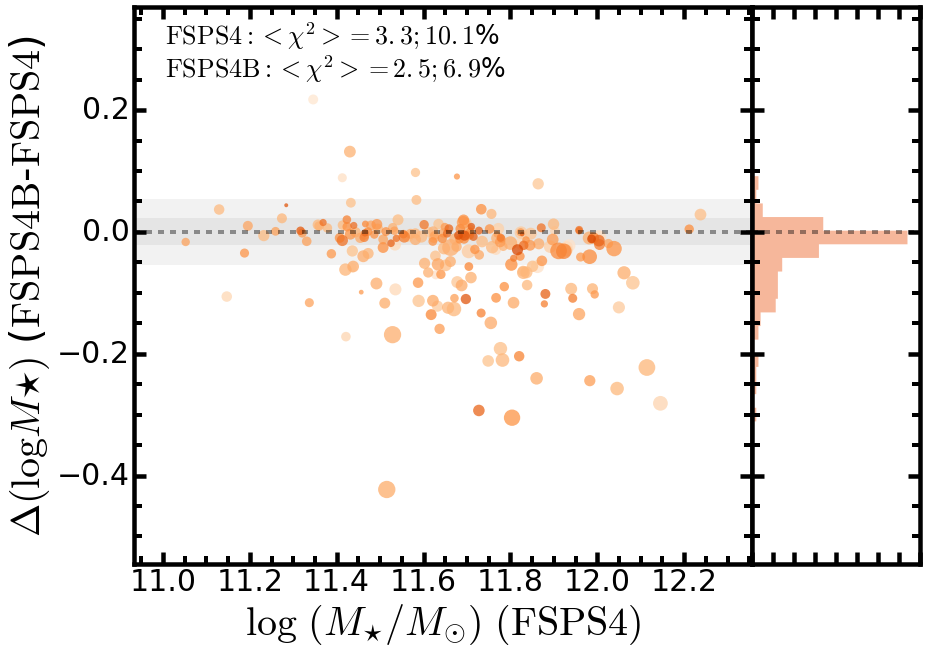

In [335]:
# ------------------------------------------------------------------------------#
# Mass v.s. Mass Difference 
fig = plt.figure(figsize=(13, 9))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)
ax1 = songPlotSetup(ax1)
ax2 = songPlotSetup(ax2)
# ------------------------------------------------------------------------------#
# Scatter plot

# Shaded region to show the typical error
tempArr = np.asarray([1.0, 20.0])
ax1.fill_between(tempArr, 
                 (tempArr * 0.0 - 3.0 * sigErr), 
                 (tempArr * 0.0 + 3.0 * sigErr), alpha=0.05, 
                 facecolor='k', edgecolor='none', interpolate=True)
ax1.fill_between(tempArr, 
                 (tempArr * 0.0 - 1.0 * medErr), 
                 (tempArr * 0.0 + 1.0 * medErr), alpha=0.05, 
                 facecolor='k', edgecolor='none', interpolate=True)

## Horionzital 0.0 Line
ax1.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.4)

# Matched ones 
fig_a = simpleScatter(xarr, yarr, xstr=None, ystr=None, 
                      titleUse=None, carr=carr, sarr=sarr, ax=ax1,
                      xmargin=xmargin, ymargin=ymargin,
                      cmap=cmapUse, maxSize=maxSizeUse, alpha=alphaUse)

# Text information about the comparison
ax1.text(0.05, 0.92, 
         strRef + '$: <{\chi}^2>=%4.1f; %4.1f$%%' % (np.nanmedian(chi2Ref), fracBadRef), 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=26.0, transform=ax1.transAxes, color='k')
ax1.text(0.05, 0.86, 
         strComp + '$: <{\chi}^2>=%4.1f; %4.1f%%$%%' % (np.nanmedian(chi2Comp), fracBadComp), 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=26.0, transform=ax1.transAxes, color='k')

# Label
ax1.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ ($' + strRef + '$)$', size=40)
ax1.set_ylabel('$\Delta(\log M{\star})\ $' + '(' + strComp + '-' + strRef + ')', 
               size=40)

# ---------------------------------------------------------------------------
# Histogram 
ax2.set_ylim(ax1.get_ylim())

## Horionzital 0.0 Line
ax2.axhline(0.0, linewidth=4.0, linestyle='--', c='k', alpha=0.4)

n, bins, patches=ax2.hist(yarr, bins=30, edgecolor='none',
                          orientation='horizontal', histtype='stepfilled', 
                          color=colorUse, alpha=0.80, normed=1)

# Axes setup
ax2.tick_params(axis='x', which='minor', bottom='off', top='off')
ax2.xaxis.set_major_formatter(NullFormatter())
ax2.yaxis.set_major_formatter(NullFormatter())

# Save the figure 
fig.savefig('%s_sed_logmdiff_%s_%s.png' % (sample0, sample1, sample2), 
            dpi=200)